## Create custom Plots from your dataset
The intend of this markdown is to provide you with the tools you need to visualize your data by selecting in a custom fassion the plots you want to create and the relationships you want to visualize.

### Table of Contents
- [First Steps](#first-steps)
    - [Import your Data](#import-your-data) ⚠️
    - [Outlier detection](#outlier-detection)
- [Create Qualitative Plots](#create-qualitative-plots)
- [Create Quantitative Plots](#create-quantitative-plots)
    - [Create a Scatterplot Matrix to visualize the all realtionships in your data](#create-a-scatterplot-matrix-to-visualize-the-all-realtionships-in-your-data)

# First Steps
### Import your Data

In [2]:
from matplotlib import image
import seaborn as sns
import pandas as pd
import rospkg
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
path = rospkg.RosPack().get_path('arena-evaluation') + '/02_evaluation'
data = pd.read_feather(path+'/data.ftr')
data['category'] = 'None'
data.loc[data.vel.notnull(),['category']] = 'var'
data.loc[data.path_length.notnull(),['category']] = 'med'

### Outlier detection
Wrong values in your dataset can, if not detected, seriously impact the evaluation accuracy. 
There are a number of different ways to check your data for outliers. As these must be choosen on a case by case basis, we provide here only a helpful selection.

In [17]:
# data.describe()
data[7:-7]

,index,Planner,Robot,World,Dyn_obs,time,collision,curvature,normalized_curvature,roughness,...,25.0,26.0,27.0,28.0,29.0,nan,centroids,counts,collisions,category
7,7,teb,jackal,map2,10.0,180.381,0.0,0.521658,0.486743,0.050231,...,"[-7.074, -7.7]","[-5.344, -4.657]","[-6.135, -6.245]","[-7.542, -7.543]","[-6.487, -6.746]",None,None,<NA>,None,med
8,8,teb,jackal,map2,10.0,34.225,0.0,47.128659,0.333521,0.041465,...,"[-6.631, -7.048]","[-4.863, -4.086]","[-5.712, -5.641]","[-7.076, -6.956]","[-5.904, -5.914]",None,None,<NA>,None,med
9,9,teb,jackal,map2,10.0,26.847,0.0,1.418483,0.505655,0.048678,...,"[-6.167, -6.37]","[-4.19, -3.656]","[-5.258, -4.996]","[-6.565, -6.315]","[-5.474, -5.304]",None,None,<NA>,None,med
10,10,teb,jackal,map2,10.0,20.054,0.0,0.18933,0.186056,0.022552,...,"[-5.636, -5.598]","[-3.548, -3.31]","[-4.802, -4.36]","[-6.076, -5.701]","[-4.998, -4.635]",None,None,<NA>,None,med
11,11,teb,jackal,map2,10.0,36.173,0.0,0.529388,0.267397,0.026802,...,"[-5.079, -4.794]","[-3.318, -2.959]","[-4.247, -3.556]","[-5.47, -4.941]","[-4.567, -4.03]",None,None,<NA>,None,med
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,386,teb,youbot,map5,10.0,<NA>,<NA>,<NA>,<NA>,<NA>,...,"[-0.362, -8.211]",None,"[-4.925, -8.78]","[-2.821, -0.07]",None,None,None,<NA>,None,None
480,387,teb,youbot,map5,10.0,<NA>,<NA>,<NA>,<NA>,<NA>,...,"[-0.359, -8.211]",None,"[-4.821, -8.793]","[-3.048, -0.014]",None,None,None,<NA>,None,None
481,388,teb,youbot,map5,10.0,<NA>,<NA>,<NA>,<NA>,<NA>,...,"[-0.355, -8.211]",None,"[-4.923, -8.778]","[-3.204, 0.021]",None,None,None,<NA>,None,None
482,389,teb,youbot,map5,10.0,<NA>,<NA>,<NA>,<NA>,<NA>,...,None,None,None,"[-3.356, 0.111]",None,None,None,<NA>,None,None


# Create Qualitative Plots
Qualitative plots visualize the paths, taken by the robot in the simulated world.

In [ ]:
def get_qualitative_plots(self):
    os.mkdir(self.plot_dir + "/qualitative_plots")
    ### iteration part ###
    for map in self.maps:
        map_keys = [] # list of keys with current map
        map_path = self.maps_dict[map]
        with open(map_path+"/map.yaml") as file: # get map file from map.yaml in map directory
            map_yaml = yaml.safe_load(file)
            map_file = map_yaml["image"]
            map_resolution = map_yaml["resolution"]
            map_origin = map_yaml["origin"]
        for key in self.keys:
            if self.data[key]["map"] == map:
                map_keys.append(key) # append key if map matches current map
        for velocity in self.velocities:
            vel_keys = [] # list of keys with current velocity
            for key in map_keys:
                if self.data[key]["velocity"] == velocity:
                    vel_keys.append(key) # append key if velocity matches current velocity
            for obstacle_number in self.obstacle_numbers:
                obs_keys = [] # list of keys with the current obstacle number
                for key in vel_keys:
                    if self.data[key]["obstacle_number"] == obstacle_number:
                        obs_keys.append(key) # append key if obstacle_number matches current obstacle_number

                if len(obs_keys) == 0:
                    continue

                ### plotting part ###
                fig, ax = plt.subplots()

                # plot map image
                img= image.imread("{0}/{1}".format(map_path,map_file))
                img_rotated = ndimage.rotate(img, 90, reshape=True) # rotate by 90 degree to get rviz konvention
                plt.imshow(img_rotated, cmap="gray")

                # plot each planners path and if flag given collisions and zones
                for key in sorted(obs_keys):
                    # plot paths for every episode
                    planner = self.data[key]["planner"]
                    if planner in self.config["leave_out_planner"]:
                        continue
                    paths = self.data[key]["paths_travelled"]
                    episodes = paths.keys()
                    for i,episode in enumerate(episodes):
                        if i == 0:
                            if "3d" in planner:
                                plt.plot([],[], # plot legend only with empty lines
                                "--",
                                label = self.config["labels"][planner],
                                alpha = self.config["path_3D_alpha"],
                                color = self.config["color_scheme"][planner],
                                linewidth = 2)
                            else:
                                plt.plot([],[], # plot legend only with empty lines
                                "-",
                                label = self.config["labels"][planner],
                                color = self.config["color_scheme"][planner],
                                linewidth = 2)                                    

                        x,y = to_ros_coords(paths[episode], img, map_resolution, map_origin)
                        x = x[3:-3] # NOTE: sometimes episode is wrongly assigned _> skip first and last coordinates
                        y = y[3:-3]
                        if "3d" in planner:
                            plt.plot(x,y,
                            "--",
                            color = self.config["color_scheme"][planner],
                            alpha = self.config["path_3D_alpha"],
                            linewidth = self.config["path_size"]/map_resolution,zorder=1)
                        else:
                            plt.plot(x,y,
                            "-",
                            color = self.config["color_scheme"][planner],
                            alpha = self.config["path_alpha"],
                            linewidth = self.config["path_size"]/map_resolution,zorder=1)

                        if self.config["plot_progression"]:
                            x_progression = x[0::self.config["plot_progression_steps"]]
                            y_progression = y[0::self.config["plot_progression_steps"]]
                            plt.scatter(x_progression,y_progression,
                            color = self.config["color_scheme"][planner],
                            alpha = self.config["path_alpha"],
                            s = self.config["plot_progression_size"]/map_resolution,zorder=1)

                    # plot collisions
                    if self.config["plot_collisions"]:
                        collisions = self.data[key]["collision_zones"]["collisions"]
                        if len(collisions) != 0:
                            x,y = to_ros_coords(collisions, img, map_resolution, map_origin)
                            plt.scatter(x,y,
                                color = self.config["color_scheme"][planner],
                                alpha = self.config["collision_alpha"],
                                s = self.config["collision_size"]/map_resolution,zorder=2)
                    # plot collision zones and centroids
                    if self.config["plot_collision_zones"]:
                        centroids = self.data[key]["collision_zones"]["centroids"]
                        if len(centroids) != 0:
                            counts = self.data[key]["collision_zones"]["counts"]
                            x,y = to_ros_coords(centroids, img, map_resolution, map_origin)
                            plt.scatter(x,y,
                                color = self.config["color_scheme"][planner],
                                alpha = self.config["collision_alpha"],
                                s = self.config["collision_size"]/map_resolution,zorder=2)
                            for i,centroid in enumerate(centroids):
                                # plot circle for collision zone
                                ax.add_patch(plt.Circle(tuple(to_ros_coords(centroid, img, map_resolution, map_origin)),
                                radius = self.config["collision_zone_base_diameter"]*counts[i]/map_resolution,
                                color=self.config["color_scheme"][planner],
                                fill=False,zorder=2))
                                # plot transparent circle as background of zone
                                ax.add_patch(plt.Circle(tuple(to_ros_coords(centroid, img, map_resolution, map_origin)),
                                radius = self.config["collision_zone_base_diameter"]*counts[i]/map_resolution,
                                color=self.config["color_scheme"][planner],
                                fill=True,
                                alpha = self.config["collision_zone_alpha"],zorder=2))

                # plot scenario properties (start, goal, dynamic obstacles)
                self.plot_scenario(obs_keys, img,  map_resolution, map_origin)

                # plot legend, title, axes labels
                if self.config["plot_qualitative_legend"]:
                    plt.legend(loc=self.config["plot_qualitative_legend_location"], fontsize=self.config["plot_qualitative_legend_fontsize"])
                else:
                    plt.legend(loc=self.config["plot_qualitative_legend_location"], fontsize=self.config["plot_qualitative_legend_fontsize"])
                    ax.get_legend().remove()
                if self.config["plot_qualitative_title"]:
                    if obstacle_number == "base_obstacle_number" and velocity == "base_velocity":
                        plt.title("Map: {0}".format(map), fontsize = self.config["plot_qualitative_title_size"], fontweight = "bold")
                    elif obstacle_number == "base_obstacle_number":
                        plt.title("Map: {0} Velocity: {1}.{2}".format(map, velocity.replace("vel","")[0], velocity.replace("vel","")[1]), fontsize = self.config["plot_qualitative_title_size"], fontweight = "bold")
                    elif velocity == "base_velocity":
                        plt.title("Map: {0}\n Obstacles: {1}".format(map, int(obstacle_number.replace("obs",""))), fontsize = self.config["plot_qualitative_title_size"], fontweight = "bold")
                    else:
                        plt.title("Map: {0}\n Obstacles: {1} Velocity: {1}.{2} ".format(map, int(obstacle_number.replace("obs","")), velocity.replace("vel","")[0], velocity.replace("vel","")[1]), fontsize = self.config["plot_qualitative_title_size"], fontweight = "bold")
                if self.config["plot_qualitative_axes"]:
                    plt.xlabel("x in [m]", fontsize=self.config["plot_qualitative_axes_size"])
                    plt.ylabel("y in [m]", fontsize=self.config["plot_qualitative_axes_size"])
                    x_locs = ax.get_xticks()[1:-1]
                    y_locs = ax.get_yticks()[1:-1]
                    ax.set_xticks(x_locs)
                    ax.set_xticklabels([int(x*map_resolution) for x in x_locs])
                    ax.set_yticks(y_locs)
                    ax.set_yticklabels([int(y*map_resolution) for y in y_locs])
                    ax.tick_params(axis='both', which='major', labelsize=self.config["plot_qualitative_axes_ticks_size"])
                else:
                    x_locs = ax.get_xticks()[1:-1]
                    y_locs = ax.get_yticks()[1:-1]
                    ax.set_xticks(x_locs)
                    ax.set_yticks(y_locs)
                    ax.set_xticklabels([])
                    ax.set_yticks(y_locs)
                    ax.set_yticklabels([])

                # plt.xlim(right=(100+100)/map_resolution)
                # plt.ylim(bottom=(100+100)/map_resolution)

                plt.savefig(self.plot_dir + "/qualitative_plots/qualitative_plot_{0}_{1}_{2}".format(map,obstacle_number,velocity), bbox_inches='tight',dpi=200)
                fig.clear(True)
                plt.close()

def plot_scenario(self, keys, img,  map_resolution, map_origin):
    scenario_dir = rospkg.RosPack().get_path('simulator_setup') + "/scenarios"
    scenario_dict = {x.split("/")[-1].replace(".json",""):x for x in sorted(glob.glob("{0}/*.json".format(scenario_dir)))}
    for scene in sorted(scenario_dict.keys()): # check if a map in /simulator_setup/maps fits scenario name
        if scene in keys[0]:
            scenario_path = scenario_dict[scene]
    with open(scenario_path) as file:
        scenario = json.load(file)
    if "pedsim_agents" in scenario.keys():
        dynamic_obstacles = scenario["pedsim_agents"]
        obstacle_paths = [[obstacle["pos"]]+ obstacle["waypoints"] for obstacle in dynamic_obstacles]
        start_x, start_y = to_ros_coords(scenario["robot_position"], img, map_resolution, map_origin)
        goal_x, goal_y = to_ros_coords(scenario["robot_goal"], img, map_resolution, map_origin)
        obstacle_paths = transform_waypoints(obstacle_paths, img, map_resolution, map_origin, ped_sim=True)
    else:
        start = scenario["scenarios"][0]["robot"]["start_pos"]
        goal = scenario["scenarios"][0]["robot"]["goal_pos"]
        dynamic_obstacles = scenario["scenarios"][0]["dynamic_obstacles"]
        obstacle_paths = [[dynamic_obstacles[obstacle]["start_pos"][:-1]]+[waypoint[:-1] for waypoint in dynamic_obstacles[obstacle]["waypoints"]] for obstacle in dynamic_obstacles]
        start_x, start_y = to_ros_coords(start, img, map_resolution, map_origin)
        goal_x, goal_y = to_ros_coords(goal, img, map_resolution, map_origin)
        obstacle_paths = transform_waypoints(obstacle_paths, img, map_resolution, map_origin)

    # plot start point and goal
    # labels for legend only
    plt.scatter([],[], marker = self.config["start_marker"], label = "Start", color = self.config["start_point_color"])
    plt.scatter([],[], marker = self.config["goal_marker"], label = "Goal", color = self.config["goal_point_color"])
    # start and goal point
    plt.scatter(start_x,start_y, marker = self.config["start_marker"], s = self.config["start_size"]/map_resolution, color = self.config["start_point_color"],zorder=5)
    plt.scatter(goal_x,goal_y, marker = self.config["goal_marker"], s = self.config["goal_size"]/map_resolution, facecolors = "none", edgecolors = self.config["goal_point_color"],zorder=5)

    # plot dynamic obstacle path
    for path in obstacle_paths:
        # plot waypoints as circles
        for i,waypoint in enumerate(path):
            plt.gca().add_patch(plt.Circle(waypoint,
                radius = self.config["obstacle_radius"]/map_resolution,
                color=self.config["obstacle_color"],
                fill=False,zorder=5))
            if i == len(path)-1:
                continue
            plt.gca().add_patch(patches.FancyArrowPatch(waypoint, path[i+1], arrowstyle='<->', mutation_scale = self.config["path_arrow_size"], color = self.config["path_arrow_color"],zorder=5))

# Create Quantitative Plots
Quantitative Plots quantify the performance of planner and robots etc. during the simulation runs. Jump to the section of the respective plot of interest.

### Create a Scatterplot Matrix to visualize the all realtionships in your data

In [ ]:
https://seaborn.pydata.org/examples/scatterplot_matrix.html

### Violine Plot

In [ ]:
https://seaborn.pydata.org/examples/wide_form_violinplot.html

In [ ]:
sns.jointplot(data=penguins, x="flipper_length_mm", y="bill_length_mm", hue="species")
https://seaborn.pydata.org/tutorial/function_overview.html#combining-multiple-views-on-the-data
https://seaborn.pydata.org/tutorial/categorical.html

In [61]:
sample = data.loc[data.category == 'med', ['World', 'time', 'Robot']]
# for element in ['World', 'time', 'Robot']:
# sns.violinplot(x=sample.Planner, y=sample.time)
sample = sample[sample.time<179]


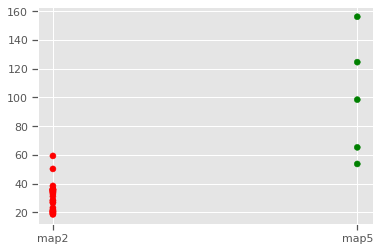

In [62]:
colors = {'jackal':'red','youbot':'green'}
plt.style.use('seaborn-dark-palette')
plt.scatter(x=sample['World'], y=sample['time'], c=sample['Robot'].map(colors));

In [63]:
robot = list(np.array(sample.Robot))
time = list(np.array(sample.time))
world = list(np.array(sample.World))

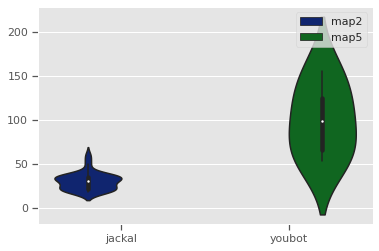

In [64]:
sns.violinplot(x=robot, y=time, hue=world);
plt.show()

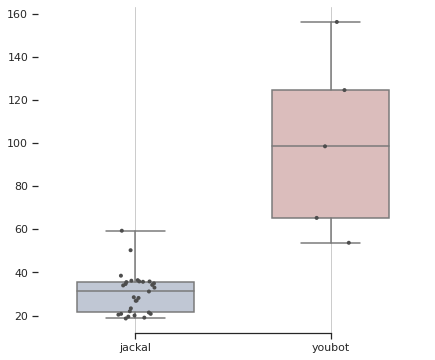

In [65]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

# Load the example planets dataset

# Plot the orbital period with horizontal boxes
sns.boxplot(x=robot, y=time, whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x=robot, y=time, size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

### 3D Plot

In [ ]:
https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py